### Removing Bad Participants from the Analysis.
1. We are removing the first **n** trials for every cue in every casino. This ensures that the participants are able to learn the pattern of every slot as we want to measure how the RewP changes in different average task values. For that the participants have to learn first what the average task value is of every slot.
2. We are removing participants that do not manage to get **threshold** of the learnable trials correct, i.e. choosing the lever with the higher win probability. Thus, we assume that participants did not truly care about the reward. As we want to measure the RewP in different averaging task values, this requires participants to truly want to win corresponding to dopamine release on a win.

In [14]:
import os
import pandas as pd
from utils import copyanything

# HYPERPARAMS
n = 4
threshold = 0.7


subjects_dir = 'Dataset/ds004147'
copyanything(subjects_dir, f"{subjects_dir}-filtered")
subjects_dir = f"{subjects_dir}-filtered"
subject_dirs = [d for d in os.listdir(subjects_dir) if os.path.isdir(os.path.join(subjects_dir, d))]
removed_trial_dict = {}
for subject_dir in subject_dirs:
    beh_file_path_tsv = os.path.join(subjects_dir, subject_dir, 'beh', f'{subject_dir}_task-casinos_beh.tsv')
    if os.path.exists(beh_file_path_tsv):
        df = pd.read_csv(beh_file_path_tsv, sep='\t')
        # remove the first four trials for every cue and block
        filtered_df = df.groupby(['block', 'cue']).apply(lambda x: x.iloc[4:]).reset_index(drop=True)
        filtered_df = filtered_df[filtered_df['invalid'] != 1]
        removed_trials = df.groupby(['block', 'cue']).apply(lambda x: x.iloc[:4]).reset_index(drop=True)
        removed_trials["trial"] = removed_trials["trial"] + (removed_trials["block"] - 1) * 144
        removed_trial_dict[subject_dir] = removed_trials
        df_sorted = filtered_df.sort_values(by=['block', 'trial'])
        # aggregate learnable trials and mark participants that did not meet the threshold
        learnable_trials = filtered_df[filtered_df['prob'] == 80]
        correct_choices = learnable_trials['outcome'] == learnable_trials['optimal']
        success_rate = correct_choices.mean()
        threshold_met = success_rate >= threshold
        if threshold_met:
            print(f"{subject_dir} does meet the threshold and should be included in the analysis.")
            df_sorted.to_csv(os.path.join(subjects_dir, subject_dir, 'beh', f'{subject_dir}_task-casinos_beh.tsv'), sep='\t', index=False)
        else:
            print(f"{subject_dir} does  not meet the threshold and should be not included in the analysis.")
            df_sorted.to_csv(os.path.join(subjects_dir, subject_dir, 'beh', f'{subject_dir}_REJECT_task-casinos_beh.tsv'), sep='\t', index=False)
    else:
        print(f'Behavioral directory for {subject_dir} does not exist.')

Behavioral directory for .git does not exist.
Behavioral directory for code does not exist.
sub-27 does meet the threshold and should be included in the analysis.
sub-28 does meet the threshold and should be included in the analysis.
sub-29 does meet the threshold and should be included in the analysis.
sub-30 does meet the threshold and should be included in the analysis.
sub-31 does meet the threshold and should be included in the analysis.
sub-32 does meet the threshold and should be included in the analysis.
sub-33 does meet the threshold and should be included in the analysis.
sub-34 does meet the threshold and should be included in the analysis.
sub-35 does meet the threshold and should be included in the analysis.
sub-36 does meet the threshold and should be included in the analysis.
sub-37 does meet the threshold and should be included in the analysis.
sub-38 does meet the threshold and should be included in the analysis.



After choosing n=4 and threshold=0.7, no participants went under the threshold. The authors noted that some were excluded, so we believe that these participants where from the other test site.

### Filter the first n=4 trials for every slot in every casino for every participant
During the removal of bad participants, we also returned a filtered beh.tsv without the first n=4 trials. We do this for the eeg.vmrk and events.tsv files, respectively. Moreover, invalid trials are also removed, as the data is unnecessary.


In [15]:
from mne_bids import (BIDSPath,read_raw_bids)
import mne
import tqdm
import pickle 

# path where to save the datasets.
bids_root = subjects_dir
invalid_tracker = {}
for subject_dir in subject_dirs:
    eeg_vmrk_path = os.path.join(subjects_dir, subject_dir, 'eeg', f'{subject_dir}_task-casinos_eeg.vmrk')
    eee_events_tsv_path = os.path.join(subjects_dir, subject_dir, 'eeg', f'{subject_dir}_task-casinos_events.tsv')
    eeg_events_json_path = os.path.join(subjects_dir, subject_dir, 'eeg', f'{subject_dir}_task-casinos_events.json')
    if os.path.exists(eeg_vmrk_path):
        with open(eeg_vmrk_path, 'r') as file:
            lines = file.readlines()
        start_index = 13  
        groups = []
        current_group = []
        for i, line in enumerate(lines[start_index:], start=start_index):
            if any(stim in line for stim in ['S  1', 'S 11', 'S 21', 'S 31']):
                if current_group:
                    groups.append(current_group)
                    current_group = []
            current_group.append(i)
        if current_group:
            groups.append(current_group)
        groups = [(idx+1, element) for idx, element in enumerate(groups)]
        invalid = [(idx, element) for idx, element in groups if len(element) != 5]  # filter invalid trials, i.e. sublist != 5
        invalid_idxs = [element[0] for element in invalid]
        invalid_tracker[subject_dir] = [0 if idx not in invalid_idxs else 1 for idx in range(len(groups))]
        print(f"Subject: {subject_dir} had {len(invalid)} invalid trials!")
        # filter the 4 trials for every slot in every casino
        first_four = [(idx, item) for idx, item in groups if idx in removed_trial_dict[subject_dir]["trial"].values]
        first_four_invalid= [item for item in first_four if len(item[1]) != 5]
        # remove duplicate in invalid (invalid trials could be in the first four trials of a slot)
        invalid = [item for item in invalid if item not in first_four_invalid]
        first_four.extend(invalid)
        # convert to list of lines to remove
        first_four = [element[1] for element in first_four]
        lines_to_remove = []
        [lines_to_remove.extend(element) for element in first_four]
        filtered_lines = [line for idx, line in enumerate(lines) if idx not in lines_to_remove]
        
        # create filtered vrmk file
        #print(f"Adapting eeg.vmrk and events.tsv file for {subject_dir}")
        with open(os.path.join(subjects_dir, subject_dir, 'eeg', f'{subject_dir}_task-casinos_eeg.vmrk'), "w") as file:
            # Write each item to the file
            for item in filtered_lines:
                file.write(item)
        
        
        # do the same for events.tsv file
        with open(eee_events_tsv_path, 'r') as file:
            lines = file.readlines()
        lines_to_remove = [idx - 10 for idx in lines_to_remove]
        filtered_lines = [line for idx, line in enumerate(lines) if idx not in lines_to_remove]
        with open(os.path.join(subjects_dir, subject_dir, 'eeg', f'{subject_dir}_task-casinos_events.tsv'), "w") as file:
            # Write each item to the file
            for item in filtered_lines:
                file.write(item)
    else:
        print(f'eeg.vmrk file for {subject_dir} does not exist.')

with open('invalid_trials.pkl', 'wb') as f:
    pickle.dump(invalid_tracker, f)

eeg.vmrk file for .git does not exist.
eeg.vmrk file for code does not exist.
Subject: sub-27 had 5 invalid trials!
Subject: sub-28 had 2 invalid trials!
Subject: sub-29 had 91 invalid trials!
Subject: sub-30 had 19 invalid trials!
Subject: sub-31 had 7 invalid trials!
Subject: sub-32 had 59 invalid trials!
Subject: sub-33 had 25 invalid trials!
Subject: sub-34 had 16 invalid trials!
Subject: sub-35 had 12 invalid trials!
Subject: sub-36 had 29 invalid trials!
Subject: sub-37 had 16 invalid trials!
Subject: sub-38 had 7 invalid trials!


### Cue-related Stimuli choice
Now we are loading the dataset and first analyze the different cue stimuli (e.g. high-task and low-cue, medium-task and high-cue etc.). Usually, we would have to take the stimuli which is responsible for the onset of the cue, but due to missing cue and task combinations in the sub-X_task-casinos_events.json, we instead take the stimuli which corresponds to the beep, i.e. S3, S13, S23 and S33. 

<img alt="image" src="Paper/trial_pipeline.jpg" width="1500"/>

To make our workaround of using beep stimuli work, we will set the Epoch range to -1200ms and -600ms, which matches with the range the authors have used. As can be seen from the trial pipeline (the step after the fixation cross equates to the cue onset), setting the time range like this would correspond to -200ms and 600ms for the cue onset stimulus.

## Invalid Trials over Time
The complete experiment run for each subject is really long (**amount of time and number of breaks**). So we hypothesize that some subjects could feel tired after a couple of hours in the experiment. We use the number of invalid trials over time as an approximate to see if participant is tired. Specifically, if the number of errors increases in the course of the experiment, we assume that this is due to exhaustion or boredom, which will be reflected in an increase of alpha waves.

To check our hypothesis, we first plot the number of trials for each participant over time.

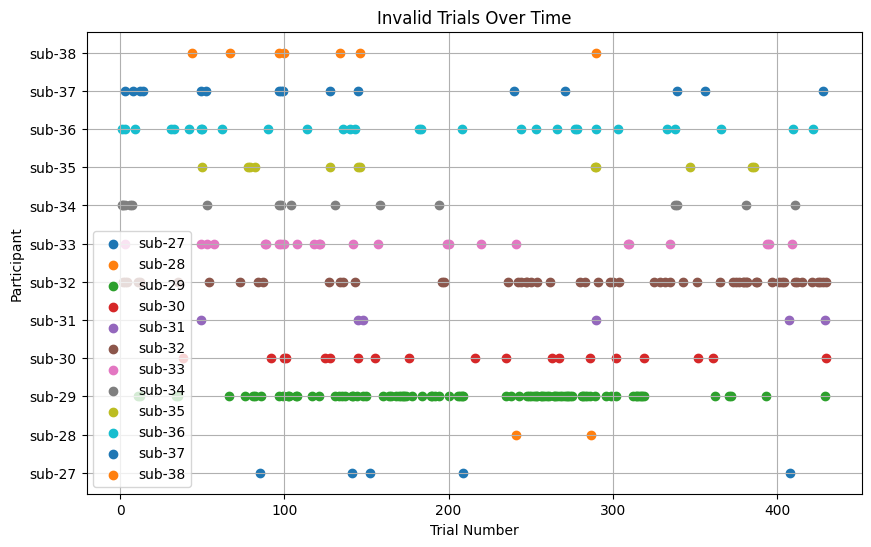

In [17]:
import matplotlib.pyplot as plt

# unpickle the invalid_trials dict: [subject, list of 0 and 1 for invalid or not in order of trials done]
with open('invalid_trials.pkl', 'rb') as f:
    invalid_trials = pickle.load(f)
    
def plot_invalid_trials_over_time_stacked(participant_data):
    plt.figure(figsize=(10, 6))

    for idx, (participant, trials) in enumerate(participant_data.items()):
        invalid_trials = [i for i, invalid in enumerate(trials) if invalid == 1]
        plt.scatter(invalid_trials, [idx + 1] * len(invalid_trials), marker='o', label=participant)

    plt.title('Invalid Trials Over Time')
    plt.xlabel('Trial Number')
    plt.ylabel('Participant')
    plt.yticks(list(range(1, len(participant_data) + 1)), list(participant_data.keys()))
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_invalid_trials_over_time_stacked(invalid_trials)